# Analysis

In this stage, we convert the connectome and the lineage tree into NetworkX objects, and store them for further processing as graphml files.

In [20]:
# !pip3 install networkx numpy pandas git+https://github.com/aplbrain/mossDB tqdm matplotlib seaborn joblib statsmodels

In [2]:
import networkx as nx
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
from tqdm.auto import tqdm

import itertools

from dlcutils import Config, fold_connectome, shuffle_connectome_renamed


In [18]:
LINEAGE = Config.get_lineage_graph()
ORIGINAL_CONNECTOME = Config.get_connectome()
CONNECTOME = fold_connectome(ORIGINAL_CONNECTOME) if Config.FOLD_CONNECTOME else ORIGINAL_CONNECTOME
NULL_MODEL = False

if NULL_MODEL:
    CONNECTOME = shuffle_connectome_renamed(CONNECTOME)

Could not find location for neuron [AIZR].
Could not find location for neuron [BWM-DR04].
Could not find location for neuron [BWM-DL07].
Could not find location for neuron [BWM-DR05].
Could not find location for neuron [BWM-DR07].
Could not find location for neuron [BWM-VL05].
Could not find location for neuron [BWM-DL01].
Could not find location for neuron [BWM-DL02].
Could not find location for neuron [BWM-DR01].
Could not find location for neuron [BWM-DR02].
Could not find location for neuron [BWM-VL02].
Could not find location for neuron [BWM-VL04].
Could not find location for neuron [BWM-VR01].
Could not find location for neuron [BWM-VR02].
Could not find location for neuron [BWM-VL01].
Could not find location for neuron [BWM-VR04].
Could not find location for neuron [BWM-VR03].
Could not find location for neuron [BWM-DR06].
Could not find location for neuron [BWM-VR06].
Could not find location for neuron [BWM-DL04].
Could not find location for neuron [BWM-DL06].
Could not find lo

## Compute Distances

This is a slow process.

In [4]:
# Compute distances between all nodes in the lineage.

if Config.COMPUTE_LINEAGE_DISTANCE_PARALLEL:
    lineage_distances = {(u, v): res for u, v, res in Parallel(n_jobs=-1)(
        delayed(lambda u, v: (u, v, Config.LINEAGE_DISTANCE_METRIC(LINEAGE, u, v)))(u, v)
        for u, v in tqdm(itertools.product(LINEAGE.nodes, LINEAGE.nodes))
        if u.upper() in CONNECTOME and v.upper() in CONNECTOME
    )}
else:
    lineage_distances = {
        (u, v): Config.LINEAGE_DISTANCE_METRIC(LINEAGE, u, v)
        for u, v in tqdm(itertools.product(LINEAGE.nodes, LINEAGE.nodes))
        if u.upper() in CONNECTOME and v.upper() in CONNECTOME
    }

3083536it [00:12, 255368.01it/s]


In [5]:
# Compute overlap similarities between all nodes in the connectome.

connectome_similarities = {
    (u, v): Config.CONNECTOME_SIMILARITY_METRIC(CONNECTOME, u, v)
    for u, v in tqdm(itertools.product(CONNECTOME.nodes, CONNECTOME.nodes))
}

18225it [00:00, 474412.83it/s]


In [6]:
# Compute neuron distances.

connectome_distances = {
    (u, v): Config.CONNECTOME_DISTANCE_METRIC(CONNECTOME, u, v)
    for u, v in tqdm(itertools.product(CONNECTOME.nodes, CONNECTOME.nodes))
}

18225it [00:00, 104329.37it/s]


In [7]:
_all_valid_neuron_pairs = [k for k in connectome_similarities.keys() if k in lineage_distances]

neuron_pairs = pd.DataFrame({
    "u": [k[0] for k in _all_valid_neuron_pairs],
    "u_type": [CONNECTOME.nodes[k[0]]['typ'] for k in _all_valid_neuron_pairs],
    "v": [k[1] for k in _all_valid_neuron_pairs],
    "v_type": [CONNECTOME.nodes[k[1]]['typ'] for k in _all_valid_neuron_pairs],
    "lineage_distance": [lineage_distances[k] for k in _all_valid_neuron_pairs],
    "connectome_similarity": [connectome_similarities[k] for k in _all_valid_neuron_pairs],
    "connectome_distance": [connectome_distances[k] for k in _all_valid_neuron_pairs],
})

neuron_pairs['uv_same_type'] = neuron_pairs.u_type == neuron_pairs.v_type

neuron_pairs = neuron_pairs[neuron_pairs.u < neuron_pairs.v]

for t in neuron_pairs.u_type.unique():
    neuron_pairs[f"{t}_match"] = (neuron_pairs.u_type == t) & (neuron_pairs.v_type == t)

## Visualization, Analysis, and Paper Figures

#### Figure: An example of two closely related but physically distant neurons with large overlap, and a third (physically close) neuron of the same cell type with small overlap.

In [8]:
# We're going to create a triple-neuron temporary dataframe:

all_neurons = neuron_pairs.u.append(neuron_pairs.v).reset_index(drop=True).unique()

In [9]:
triples_of_same_type = pd.DataFrame([
    (m, n, o)
    for m in all_neurons
    for n in all_neurons
    for o in all_neurons
    if m < n < o
    and CONNECTOME.nodes[m].get('typ', -1) == CONNECTOME.nodes[n].get('typ', -1) == CONNECTOME.nodes[o].get('typ', -1)
    and CONNECTOME.nodes[m].get('typ', -1) != -1
], columns=["a", "b", "c"])

In [10]:
neuron_pairs_by_uv = neuron_pairs.set_index(["u", "v"])

In [11]:
# There are a few useful properties of `triples_of_same_type`.
# First of all, m < n < o, so (m, n) will always be in neuron_pairs, and
# (n, m) will NEVER be in neuron_pairs.
# Second, all three cells have the same cell type already. So we do not have to
# filter based upon type either.

# In this step, we will find three neurons s.t.:
# * All neurons have the same type (done!)
# * Two neurons are close and distantly related
# * One neuron is far and closely related

potential_figure_triple_options = []
for i, (a, b, c) in tqdm(triples_of_same_type.iterrows(), total=len(triples_of_same_type)):
    if len(
        # A and B are close and distantly related
        neuron_pairs[
            (neuron_pairs.u == a) &
            (neuron_pairs.v == b) &
            (neuron_pairs.connectome_distance < 0.5) &
            (neuron_pairs.lineage_distance > 15)
        ]
    ) and len(
        # A and C are far and closely related
        neuron_pairs[
            (neuron_pairs.u == a) &
            (neuron_pairs.v == c) &
            (neuron_pairs.connectome_distance > 3) &
            (neuron_pairs.lineage_distance < 15)
        ]
    ):
        potential_figure_triple_options.append((a, b, c))

print(len(potential_figure_triple_options))



100%|██████████| 3953/3953 [00:05<00:00, 708.69it/s]

14


In [12]:
[
    ((a, b, c), neuron_pairs_by_uv.loc[a, b].connectome_similarity, neuron_pairs_by_uv.loc[a, c].connectome_similarity)
    for (a, b, c) in potential_figure_triple_options
    if (neuron_pairs_by_uv.loc[a, b].connectome_similarity < neuron_pairs_by_uv.loc[a, c].connectome_similarity)
]

[(('BAGR', 'RIBR', 'RMDDR'), 2, 10),
 (('BAGR', 'RIMR', 'RMDDR'), 9, 10),
 (('BAGR', 'PVT', 'RMDDR'), 2, 10),
 (('BAGR', 'GLRR', 'RMDDR'), 1, 10)]

#### Figure: Raw comparison of lineage distance and connectome similarity.

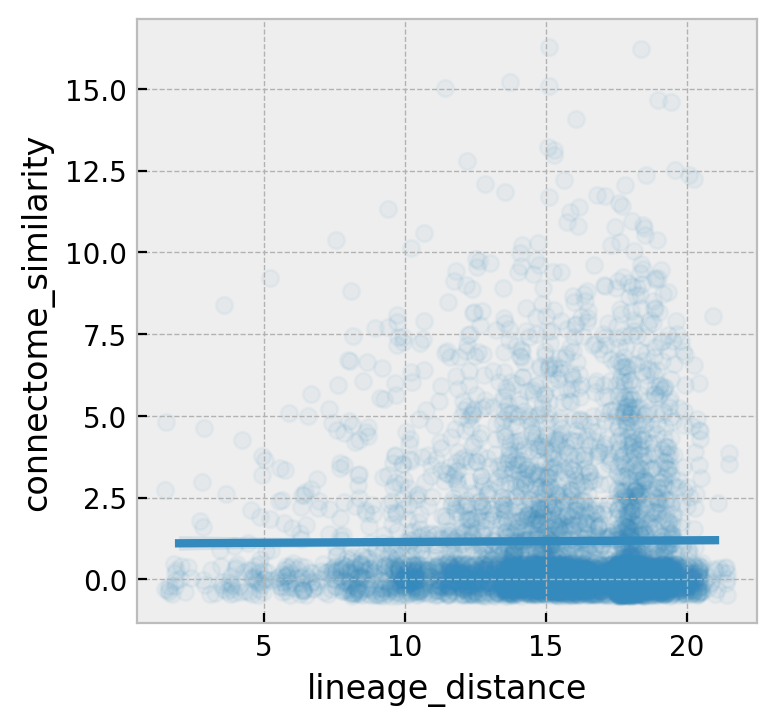

In [13]:
with plt.style.context("bmh"):
    plt.figure(figsize=(4, 4), dpi=200)
    sns.regplot(
        x="lineage_distance",
        y="connectome_similarity",
        data=neuron_pairs[neuron_pairs.u != neuron_pairs.v],
        x_jitter=0.5,
        y_jitter=0.5,
        scatter_kws=dict(alpha=0.05)
    )

#### Figure: Aggregated comparison of lineage distance and connectome similarity across several connectomes


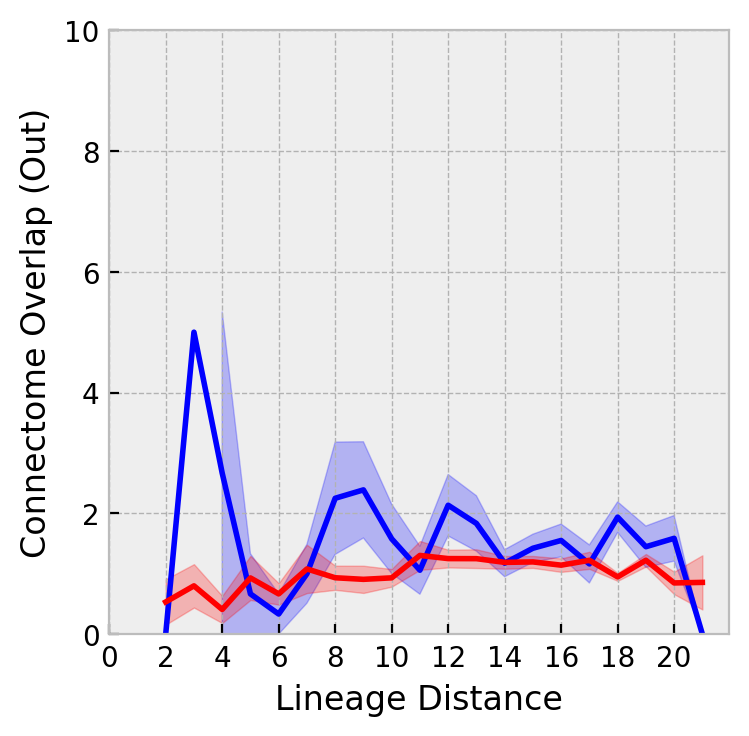

In [19]:
with plt.style.context("bmh"):
    plt.figure(figsize=(4, 4), dpi=200)

    _filtered_groupby = neuron_pairs[
        neuron_pairs.uv_same_type &
        (neuron_pairs.u != neuron_pairs.v)
    ].groupby("lineage_distance")

    sns.lineplot(
        x=_filtered_groupby.groups.keys(), 
        y=_filtered_groupby.mean().connectome_similarity,
        color='b', label="Matched cell type"
    )
    plt.fill_between(
        _filtered_groupby.groups.keys(), 
        _filtered_groupby.mean().connectome_similarity - _filtered_groupby.sem().connectome_similarity,
        _filtered_groupby.mean().connectome_similarity + _filtered_groupby.sem().connectome_similarity,
        alpha=0.25, color='b'
    )


    _filtered_groupby = neuron_pairs[
        ~neuron_pairs.uv_same_type &
        (neuron_pairs.u != neuron_pairs.v)
    ].groupby("lineage_distance")

    sns.lineplot(
        x=_filtered_groupby.groups.keys(), 
        y=_filtered_groupby.mean().connectome_similarity,
        color='r', label="Mismatched cell type"
    )
    plt.fill_between(
        _filtered_groupby.groups.keys(), 
        _filtered_groupby.mean().connectome_similarity - _filtered_groupby.sem().connectome_similarity,
        _filtered_groupby.mean().connectome_similarity + _filtered_groupby.sem().connectome_similarity,
        alpha=0.25, color='r'
    )

    plt.xlabel("Lineage Distance")
    plt.ylim(0, 10)
    plt.ylabel("Connectome Overlap (Out)")
    plt.xticks(
        range(0, int(max(_filtered_groupby.groups.keys())), 2),
        range(0, int(max(_filtered_groupby.groups.keys())), 2)
    )
    if NULL_MODEL:
        plt.savefig("figs/fig-grouped-distance-null.svg")
    else:
        plt.savefig("figs/fig-grouped-distance.svg")

    # no legend:
    plt.legend().remove()

## Cell type importances

In [15]:
results = smf.ols(
    formula="connectome_similarity ~ connectome_distance + lineage_distance + " + 
    " + ".join([f"{t}_match" for t in neuron_pairs.u_type.unique()]
), data=neuron_pairs).fit()

In [16]:
results.pvalues

Intercept              4.974932e-09
i_match[T.True]        4.386331e-06
in_match[T.True]       6.793968e-02
sm_match[T.True]       1.110446e-03
s_match[T.True]        2.359971e-01
imn_match[T.True]      5.582108e-01
sn_match[T.True]       3.409553e-02
n_match[T.True]        3.869436e-01
u_match[T.True]        9.274993e-02
m_match[T.True]        1.514157e-03
si_match[T.True]       6.330981e-01
sin_match[T.True]      9.746435e-01
mn_match[T.True]       9.746323e-01
im_match[T.True]                NaN
b_match[T.True]                 NaN
connectome_distance    8.991069e-01
lineage_distance       8.883181e-03
dtype: float64